In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Helper Functions

In [3]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')


def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

# Data

In [4]:
#Loading our dataset
df = pd.read_csv('data/zillow_data.csv')

In [5]:
#Observing what our dataset looks like
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


# Data Analysis

## Narrowing the scope of our project

Our client is looking to purchase a home in Florida. We want to identify the best 5 Zip Codes which we believe will have the highest ROI after 3 years of purchase. i.e. We want the zipcodes that we believe will appreciate the most in value. These predictions will be mades using Time Series modeling.

### Looking at our Florida data

In [6]:
#Dataframe containing only zips from Florida

florida =  df[df['State']=='FL']

In [7]:
#Observing what our Florida dataset looks like

florida

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
11,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0,100700.0,100400.0,...,249900,250400,249900,248700,247500,247100,246800,247500,249800,251800
60,72463,33160,Sunny Isles Beach,FL,Miami-Fort Lauderdale,Miami-Dade,61,337300.0,337900.0,338300.0,...,1466200,1471000,1485400,1497700,1504200,1507600,1495800,1466200,1443900,1432300
82,72363,33025,Miramar,FL,Miami-Fort Lauderdale,Broward,83,111600.0,111700.0,111800.0,...,283500,286100,287800,288800,289700,291000,292500,294200,296400,298200
83,72578,33411,Royal Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,84,126800.0,126800.0,126800.0,...,297400,299300,301400,303300,304900,307100,309800,311700,312600,313100
84,72442,33139,Miami Beach,FL,Miami-Fort Lauderdale,Miami-Dade,85,480200.0,480700.0,481200.0,...,2917100,2925700,2942400,2958300,2946300,2912900,2900900,2923300,2933600,2914100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14250,73224,34797,Yalaha,FL,Orlando,Lake,14251,86100.0,86800.0,87400.0,...,174900,177100,179100,181500,184200,186200,187200,189000,191900,193500
14262,71852,32193,Welaka,FL,Palatka,Putnam,14263,53800.0,54100.0,54300.0,...,94400,99000,100800,101000,103000,105400,104900,106100,112600,118300
14315,72384,33051,Key Colony Beach,FL,Key West,Monroe,14316,202200.0,202800.0,203400.0,...,570200,564800,561100,557300,552300,545100,542300,551500,570900,585300
14558,72865,33855,Lake Wales,FL,Lakeland,Polk,14559,NaN,NaN,NaN,...,130400,131500,134800,137900,139400,140000,140000,140300,141900,143000


## Number of ZipCodes for each Metro in Florida

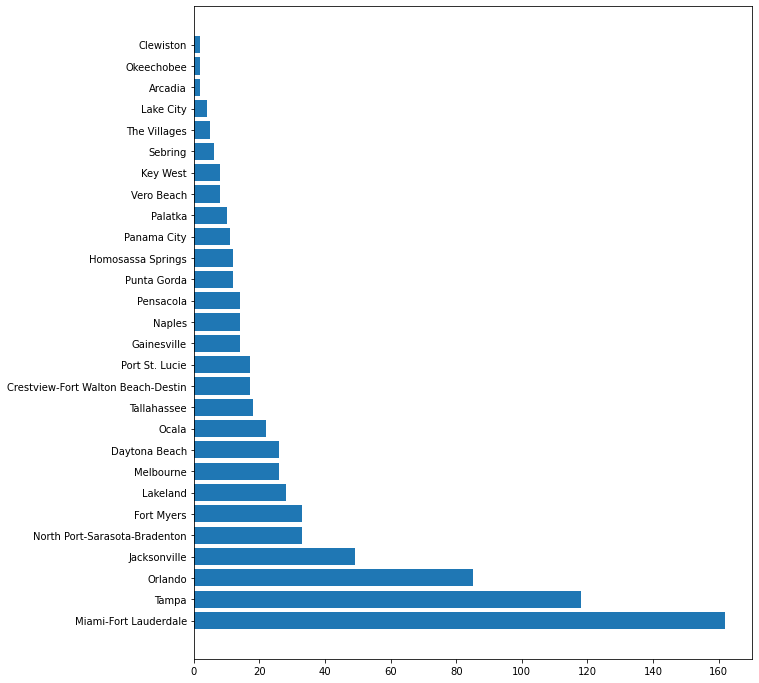

In [8]:
#Visualizing the value counts of zipcodes in each metro region in Florida

fig, ax = plt.subplots(figsize=(10,12))

y = [a for a in florida['Metro'].value_counts()]

x = [a for a in florida['Metro'].value_counts().keys()]

ax.barh(x,y);

We can see above that the Miami-Fort Lauderdale region has the highest number of zipcodes.

## Selecting a ZipCode to build our Time Series model on

We want to build a Time Series model to predict the future ROI for each zip code in Florida. But first, we will select one specific zipcode to build our time series model on. For this purpose, we decided to find the zipcode that has seen the highest growth in the 5 years since our last recorded date - April, 2018. i.e. We will find the zipcode which has grown the most between April,2015 and April,2018.

In [9]:
#Creating a new column that shows the 5 year increase in value. From April, 2013 to April, 2018.

florida['3 yr ROI'] = None
florida['3 yr ROI'] = florida['2018-04'].apply(lambda x : x-florida['2015-04'])

<ipython-input-9-9a093817bc5b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  florida['3 yr ROI'] = None
<ipython-input-9-9a093817bc5b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  florida['3 yr ROI'] = florida['2018-04'].apply(lambda x : x-florida['2015-04'])


In [10]:
#Identifying the ZipCode that grew the most between April,2013 and April,2018.

roi_df = florida[['RegionName','3 yr ROI']].sort_values('3 yr ROI',ascending = False)

print(f'Highest growing Zipcode since April 2015 is : {int(roi_df.iloc[0][0])}')

Highest growing Zipcode since April 2015 is : 33480


We will run our first Time Series model on the ZipCode- 33480 to predict what its future value will be. Then we can run a similar model on other zipcodes in the state to identify which 5 zipcodes have the highest predicted ROI.

In [11]:
#Dataframe containining historical prices of the 33480 Zip Code.

zip33480 = df[df['RegionName']==33480]

In [12]:
# Time Series dataframe of 33480 Zip Code prices

series33480 = melt_data(zip33480)

In [13]:
#Observing our Time Series dataframe

series33480

,value
time,
1996-04-01,958400.0
1996-05-01,958100.0
1996-06-01,957900.0
1996-07-01,957800.0
1996-08-01,958000.0
...,...
2017-12-01,4609000.0
2018-01-01,4626500.0
2018-02-01,4661200.0


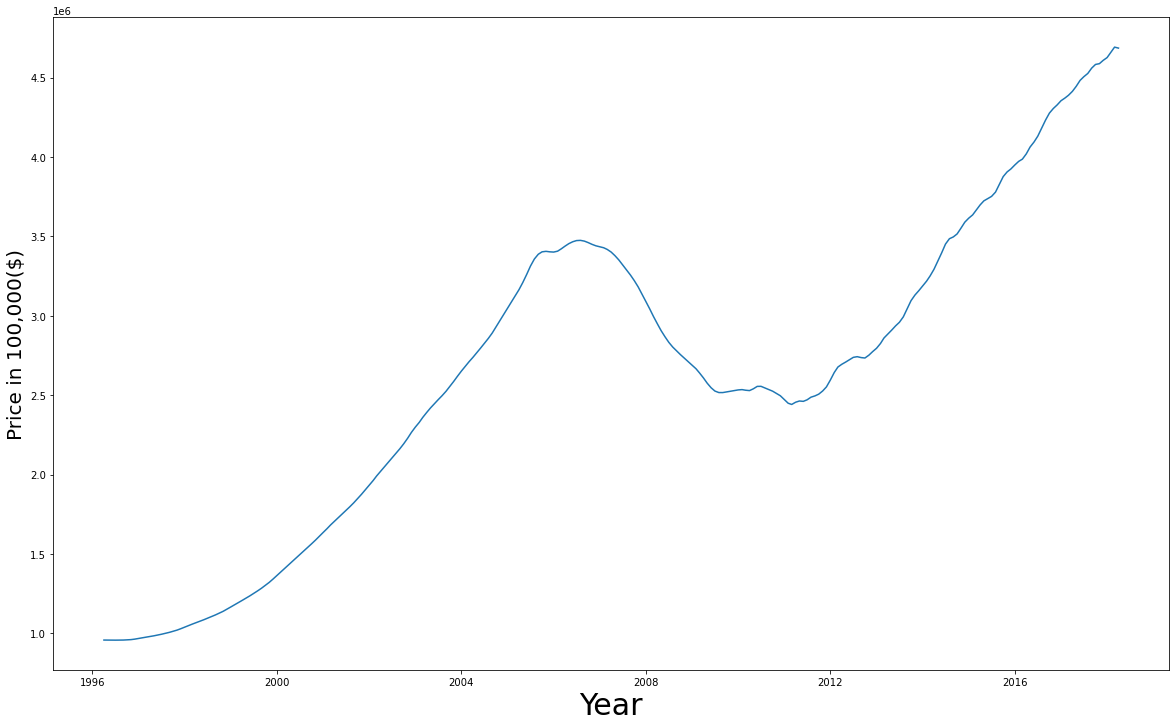

In [14]:
#Visualizing our Time Series Data

fig, ax = plt.subplots(figsize=(20,12))
ax.plot(series33480)

ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Price in 100,000($)',fontsize=20);

We can see from above that after several years of growth in the early years of the 21st Century, prices seemed to have likely fallen due to the economic crisis that emerged in 2008. Since around 2011 though, there has been a dramatic increase in prices.

# Data Pre-Processing

## Tests for Stationarity

Time series models commonly operate with the assumption that the time series is **stationary**. i.e. Over a longer period of time, the series tends not to have a trend or seasonal effects. This means that if a time series that displays a particular behavior over time, it is highly likely that it will replicate similar behavior in the future. We can perform some tests for **Stationarity** to show if the time series is stationary.

### Looking at the Rolling Statistics

In [15]:
roll_mean = series33480.rolling(window=8, center=False).mean()
roll_std = series33480.rolling(window=8, center=False).std()

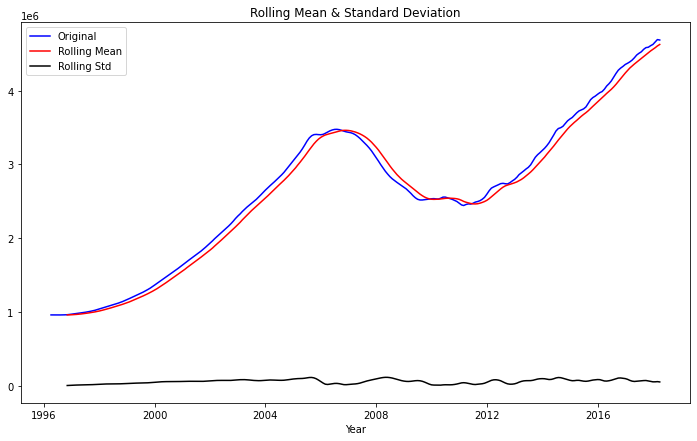

In [20]:
fig = plt.figure(figsize=(12,7))
plt.plot(series33480, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.show(block=False)

We can see that our rolling mean increases over time. This means that our time series data is not stationary.

### The Dickey-Fuller Test

Let's perform a Dickey-Fuller test to prove statistically that the time series is not stationary. For the Dickey-Fuller test, the null hypothesis is that the time series is not stationary. Therefore, in order to reject the null hypothesis, we will want a p-value of less than 0.05.

In [21]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series33480)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -1.741387
p-value                          0.409925
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


We can see from above that the test returned a p-value of 0.49. This is much higher than the 0.05 cutoff that was necessary to reject the null hypothesis. Therefore we fail to reject the null hypothesis and can conclude that the time series is not stationary. Of course this is quite intuitive just by looking at the graph, but it is always good practice to prove this statistically.

# Making our Time Series Stationary

As mentioned earlier, most models work under the assumption that the Time Series is stationary. Therefore we will need to make our current time series stationary. A common method that is used to eliminate this problem is **Differencing**.

## Differencing

In order to difference our time series, we will need to decide upon the best period value at which we want to do our differencing. Therefore we will perform a loop function to iterate over period values of 0 to 24 to find the smallest period that returns a p-value below 0.05.

In [40]:
from statsmodels.tsa.stattools import adfuller

def differencer(data):
    for i in range(0,25):
        difference = data.diff(periods=i)
        dftest = adfuller(difference[i:])
        print(i,dftest[1])

differencer(series33480)

/Users/sanjitvarma/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


0 nan
1 0.343131540861913
2 0.45148878461964975
3 0.3498779332973291
4 0.2657516719792066
5 0.2619961261754454
6 0.30968491386363906
7 0.19910839223251842
8 0.2115094850164156
9 0.37267840416752657
10 0.08902492361440495
11 0.14508366097604297
12 0.17102021265075695
13 0.06528026593849018
14 0.03683844039720054
15 0.028217511106596708
16 0.20034873851597862
17 0.39427111907187
18 0.3923268584409646
19 0.08066468289972795
20 0.15143785859299064
21 0.0324766436581636
22 0.0827926852867667
23 0.02497432287830202
24 0.03767554534847937


We can see from the above results that a period value of 14 is the smallest period that returns a p-value of less than 0.05. Therefore this is the period value we will use to perform differencing on our time series.

In [41]:
#We use .dropna() to remove the first 14 values which will return NaN.
series_diff= series33480.diff(periods=14).dropna()

Now that we have a differenced time series, let us perform our tests to check for stationarity.

## Testing our Differenced Series for Stationarity

### Differenced Time Series Rolling Statistics

In [42]:
roll_mean_diff = series_diff.rolling(window=8, center=False).mean()
roll_std_diff = series_diff.rolling(window=8, center=False).std()

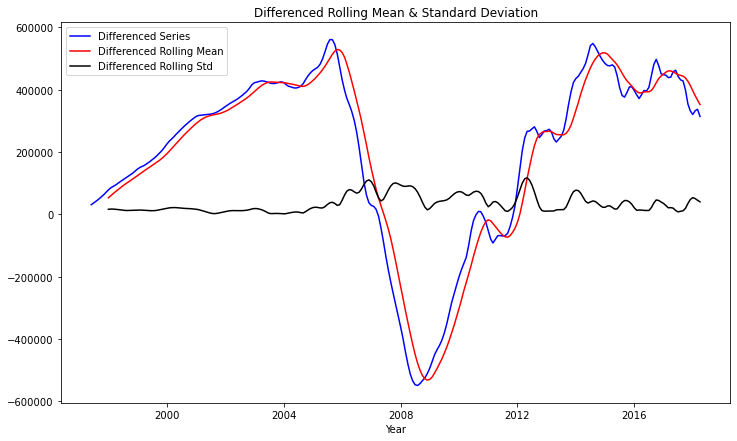

In [43]:
fig = plt.figure(figsize=(12,7))
plt.plot(series_diff, color='blue', label='Differenced Series')
plt.plot(roll_mean_diff, color='red', label='Differenced Rolling Mean')
plt.plot(roll_std_diff, color='black', label = 'Differenced Rolling Std')
plt.legend(loc='best')
plt.title('Differenced Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.show(block=False)

There is a significant drop in the rolling mean of our differenced series during the financial crisis that occurred in 2008. But the rolling mean picks back up to indicate possible stationarity over time. We can confirm this statistically by performing the Dickey-Fuller test.

### Dickey-Fuller Test on Differenced Time Series

Given that the null hypothesis is that the series is not stationary, we need a p-value of less than 0.05 to reject it.

In [45]:
dftest_diff = adfuller(series_diff)

# Extract and display test results in a user friendly manner
dfoutput_diff = pd.Series(dftest_diff[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print ('Results of Dickey-Fuller test: \n')

print(dfoutput_diff)

Results of Dickey-Fuller test: 

Test Statistic                  -2.979656
p-value                          0.036838
#Lags Used                      15.000000
Number of Observations Used    235.000000
dtype: float64


A p-value of 0.036838 is less than 0.05 and therefore we can reject the null hypothesis and conclude that the series is now stationary.